In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd ./drive/MyDrive

/content/drive/MyDrive


In [3]:
import sys
import os
py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath(py_file_location))

In [153]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingClassifier


% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random_deletion
import imputers
import utils

from importlib import reload


In [5]:
reload(imputers)
reload(utils)

<module 'utils' from '/content/drive/MyDrive/utils.py'>

# One-hot encoding и разделение данных на train и test

In [6]:
def code_myohe(data, feature):
    for i in data[feature].unique():
        data[feature + '=' + str(i)] = (data[feature] == i).astype(float)

In [322]:
df = pd.read_excel("task.xlsx")
df = df.drop('num', axis = 1)
df = df.replace(-1000.0, np.NaN)

code_myohe(df, 'Пол')
df = df.drop('Пол', axis = 1)
code_myohe(df, 'Диагноз')
df = df.drop('Диагноз', axis = 1)
code_myohe(df, 'Аппетит')
df = df.drop('Аппетит', axis = 1)
code_myohe(df, 'Ожирение')
df = df.drop('Ожирение', axis = 1)

X = df.iloc[:, 1:]
y = df.iloc[:, 0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=6666)
print("Пропуски в данных:")
df.isna().mean(axis=0)

Пропуски в данных:


исход         0.000000
Возраст       0.000000
Длит.забол    0.000000
V-талии       0.000000
ИМТ-1         0.000000
Глюкоза-1     0.000000
Холест-1      0.000000
Пролакт-1     0.006803
Эстр-1        0.000000
Тестост-1     0.156463
Кортиз-1      0.006803
ДГЭА-С-1      0.006803
Триглиц-1     0.482993
ЛПНП-1        0.517007
ЛПВП-1        0.517007
Пол=1         0.000000
Пол=2         0.000000
Диагноз=2     0.000000
Диагноз=3     0.000000
Диагноз=4     0.000000
Диагноз=5     0.000000
Диагноз=6     0.000000
Диагноз=8     0.000000
Диагноз=7     0.000000
Диагноз=1     0.000000
Аппетит=3     0.000000
Аппетит=2     0.000000
Аппетит=1     0.000000
Ожирение=2    0.000000
Ожирение=3    0.000000
Ожирение=1    0.000000
dtype: float64

# Оценка важности признаков на тренировочнй выборке (без пропусков)

In [8]:
df_without_missing = X_train.copy()
df_without_missing['исход'] = y_train.copy()
X_train_without_missings = df_without_missing[X_train['Пролакт-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['Тестост-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['ДГЭА-С-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['Триглиц-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['ЛПНП-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['ЛПВП-1'].notna()]
X_train_without_missings = X_train_without_missings[X_train_without_missings['Кортиз-1'].notna()]

In [9]:
X_train_without_missings.columns # Тестост-1 == 8 # Триглиц-1 == 11 # ЛПНП-1 == 12 # ЛПВП-1 == 13

Index(['Возраст', 'Длит.забол', 'V-талии', 'ИМТ-1', 'Глюкоза-1', 'Холест-1',
       'Пролакт-1', 'Эстр-1', 'Тестост-1', 'Кортиз-1', 'ДГЭА-С-1', 'Триглиц-1',
       'ЛПНП-1', 'ЛПВП-1', 'Пол=1', 'Пол=2', 'Диагноз=2', 'Диагноз=3',
       'Диагноз=4', 'Диагноз=5', 'Диагноз=6', 'Диагноз=8', 'Диагноз=7',
       'Диагноз=1', 'Аппетит=3', 'Аппетит=2', 'Аппетит=1', 'Ожирение=2',
       'Ожирение=3', 'Ожирение=1', 'исход'],
      dtype='object')

In [10]:
cv_results = cross_validate(xgb.XGBClassifier(eval_metric='mlogloss'), X_train_without_missings.iloc[:, :-1], X_train_without_missings.iloc[:, -1:], cv = 3, scoring='roc_auc')
cv_results['test_score']

array([0.66666667, 0.62121212, 0.62121212])

[0.05315413 0.21484838 0.08300649 0.04647695 0.03740726 0.06096957
 0.03903607 0.0387449  0.01842745 0.05302382 0.05562946 0.02507614
 0.04909533 0.08184084 0.0446944  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.03390538 0.00571212 0.         0.02337974 0.03557168]


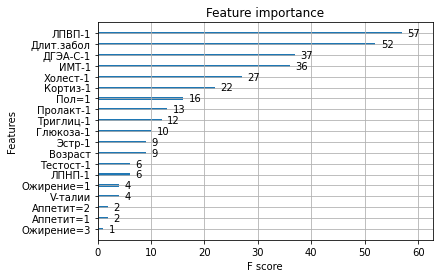

In [ ]:
clf = xgb.XGBClassifier(eval_metric='mlogloss').fit(X_train_without_missings.iloc[:, :-1], X_train_without_missings.iloc[:, -1:])
print(clf.feature_importances_)
xgb.plot_importance(clf)

# Сравнение различных способов замен пропусков
Я удаляю из X_train все объекты хотя бы с одним пропуском и делаю рандомизированные пропуски в данных. 
Затем провожу различные способы замен пропусков для определения лучших.

Исследую зависимость среднеквадратичного отклонения между восстановленными
и истинными данными от доли пропущенных значений (RMSE).

И зависимость точности классификации от доли пропущенных значений (ROC_AUC).

Я провёл такие же эксперименты как в курсовой работе студента ММП 2016
http://www.machinelearning.ru/wiki/images/9/90/Kayumov_course_work_imputer_methods.pdf


In [ ]:
X = X_train_without_missings.iloc[:, :-1]
y = X_train_without_missings.iloc[:, -1:]

In [ ]:
algorithms = [
    ('xgb', xgb.XGBClassifier(eval_metric='mlogloss')),
    ('lr', LogisticRegression(C=1.0, penalty='l2'))
]

X = np.array(X, dtype='float')
y  = np.array(y)

X_del_columns =  [11, 12, 13] # Триглиц-1 == 11 # ЛПНП-1 == 12 # ЛПВП-1 == 13

In [ ]:
def checker(algo):
    if algo[0] != 'xgb':
        return 0
    else:
        return -1

answer = {}
missing_frac_range = [0.051]
num_iter = 7
for algo in algorithms:
    rocauc_X_rf, rmse_X_rf = utils.make_experiments(X, y, algo[1], 4, missing_frac_range, 
                                                        num_iter=num_iter, sp_value=checker(algo), add_binary=False, 
                                                        del_columns = X_del_columns)
    
    rocauc_X_rf.drop('ignore', axis=0, inplace=True)
    rmse_X_rf.drop('ignore', axis=0, inplace=True)
    answer[algo[0]] = (rocauc_X_rf, rmse_X_rf)

start fraction: 0.051
start fraction: 0.051


In [ ]:
answer['lr'][0]

,0.051
special,0.649702
common,0.646032
mean,0.653671
svd,0.646726
knn,0.641964
rf,0.646825
lr,0.656052
em,0.653869
k-means,0.650298
zet,0.666964


In [ ]:
answer['xgb'][0]

,0.051
special,0.576984
common,0.571925
mean,0.585119
svd,0.588988
knn,0.610913
rf,0.613790
lr,0.590873
em,0.585317
k-means,0.589484
zet,0.596925


# Итог: Большинство методов замены показали очень схожие результаты, поэтому выбор лучшего остаётся на кросвалидацию с полным X_train

In [8]:
class Special_value(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self, special_value = -1):
        self.special_value = special_value
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.special_value_imputer(X, self.special_value, add_binary=False)
        return X

class Common_value_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.common_value_imputer(X, add_binary=False)
        return X

class Mean_value_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.mean_value_imputer(X, add_binary=False)
        return X

class Svd_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.svd_imputer(X, rank=X.shape[1] // 2, add_binary=False)
        return X

class Knn_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.knn_imputer(X, self.n_neighbors, add_binary=False)
        return X

class Rf_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.rf_imputer(X, add_binary=False)
        return X

class Linear_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.linear_imputer(X, add_binary=False)
        return X

class Em_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.em_imputer(X, add_binary=False)
        return X

class Kmean_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.kmean_imputer(X, add_binary=False)
        return X

class Zet_imputer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''
    def __init__(self, competent_row_num=6, competent_col_num=4):
        self.competent_row_num = competent_row_num
        self.competent_col_num = competent_col_num
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = imputers.zet_imputer(X, self.competent_row_num, self.competent_col_num, add_binary=False)
        return X

# Сравнение разных методов замена на кросс валидации

In [9]:
Imputers = [
            ('special', Special_value()),
            ('common', Common_value_imputer()),
            ('mean', Mean_value_imputer()),
            ('svd', Svd_imputer()),
            ('knn', Knn_imputer()),
            ('rf', Rf_imputer()),
            ('lr', Linear_imputer()),
            ('em', Em_imputer()),
            ('k-means', Kmean_imputer()),
            ('zet', Zet_imputer())
]

In [ ]:
for i in Imputers:
    parameters = {}
    if i[0] == 'knn':
        parameters = {"knn__n_neighbors" : [2, 3, 4, 5]}
    if i[0] == 'special':
        parameters = {"special__special_value" : [0, -1, -1000, 1000, 10000000, -10000000]}
    if i[0] == 'zet':
        parameters = {"zet__competent_row_num" : [6], "zet__competent_col_num" : [4]}
    pipe_xgboost = Pipeline([
                 i,
                 ('xgb', xgb.XGBClassifier(eval_metric='mlogloss') )]
                )
    pipe_lr = Pipeline([
                 i,
                 ('logr', LogisticRegression(C=1.0, penalty='l2'))]
                )
    print("logr", i[0])
    clf = GridSearchCV(pipe_lr, parameters, cv = 10, scoring = 'roc_auc').fit(X_train.to_numpy(), y_train.to_numpy())
    print(clf.cv_results_['mean_test_score'])
    print("xgb", i[0])
    clf = GridSearchCV(pipe_xgboost, parameters, cv = 10, scoring = 'roc_auc').fit(X_train.to_numpy(), y_train.to_numpy())
    print(clf.cv_results_['mean_test_score'])

logr special
[0.66       0.67       0.66333333 0.67333333 0.71       0.75666667]
xgb special
[0.69666667 0.69666667 0.69666667 0.63666667 0.63666667 0.69666667]
logr common
[0.57666667]
xgb common
[0.49666667]
logr mean
[0.55666667]
xgb mean
[0.53]
logr svd
[0.56666667]
xgb svd
[0.52]
logr knn
[0.56666667 0.56333333 0.58333333 0.58      ]
xgb knn
[0.55       0.44333333 0.44333333 0.51666667]
logr rf
[0.57]
xgb rf
[0.57333333]
logr lr
[0.55666667]
xgb lr
[0.43333333]
logr em
[0.56333333]
xgb em
[0.58]
logr k-means
[0.54333333]
xgb k-means
[0.49]


# Как видно из результатов, лучшей заменой для имеющихся алгоритмов является - специальное значение

# Перебор гиперпараметров Решающих деревьев

In [10]:
pipe_xgboost = Pipeline([
                 ('special', Special_value(-10000000)),
                 ('xgb', xgb.XGBClassifier(eval_metric='mlogloss'))]
)

In [ ]:
X_tr = X_train.to_numpy()
y_tr = y_train.to_numpy()

param_grid = {
        'xgb__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'xgb__min_child_weight': np.arange(0.0001, 0.5, 0.001),
        'xgb__gamma': np.arange(0.0,40.0,0.005),
        'xgb__learning_rate': np.arange(0.0005,0.3,0.0005),
        'xgb__subsample': np.arange(0.01,1.0,0.01),
        'xgb__colsample_bylevel': np.round(np.arange(0.1, 1.0, 0.01)),
        'xgb__colsample_bytree': np.arange(0.1, 1.0, 0.01),
}
clf = RandomizedSearchCV(pipe_xgboost, param_grid, cv = 10, scoring = 'roc_auc', verbose=10, n_iter = 50000).fit(X_tr, y_tr)

,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__gamma,param_xgb__learning_rate,param_xgb__subsample,param_xgb__colsample_bylevel,param_xgb__colsample_bytree,mean_test_score
30361,10,0.2071,7.545,0.2675,0.99,1.0,0.54,0.828333
40912,4,0.2831,12.14,0.0345,0.68,0.0,0.75,0.820000
4426,10,0.1881,9.455,0.1515,0.97,1.0,0.24,0.818333
17762,5,0.1861,8.1,0.2945,0.99,1.0,0.31,0.818333
42064,7,0.1391,9.25,0.119,0.99,1.0,0.56,0.818333
40306,6,0.4931,9.025,0.1635,0.99,1.0,0.54,0.818333
3161,4,0.1091,5.015,0.133,0.99,1.0,0.55,0.815000
46252,3,0.1771,12.595,0.135,0.7,0.0,0.76,0.813333
21437,12,0.1731,7.06,0.115,0.99,1.0,0.72,0.813333
10996,9,0.4261,6.84,0.272,0.98,1.0,0.74,0.813333


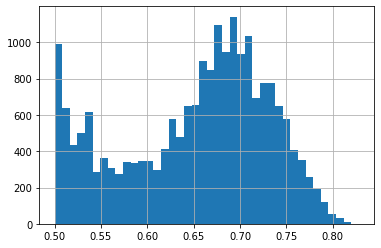

In [18]:
pd.Series(clf.cv_results_['mean_test_score'][clf.cv_results_['mean_test_score'] > 0.5]).hist(bins = 40)
results = pd.DataFrame(clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.to_csv("results.csv")
results.iloc[0:10, :].loc[:, ['param_xgb__max_depth', 'param_xgb__min_child_weight','param_xgb__gamma', 'param_xgb__learning_rate', 'param_xgb__subsample', 'param_xgb__colsample_bylevel', 'param_xgb__colsample_bytree' , 'mean_test_score']]

In [79]:
best = np.argsort(clf.cv_results_['rank_test_score'])
best_estimators = np.array(clf.cv_results_['params'])[best]
for i in range(0, len(best_estimators)):
    first = best_estimators[i]
    first['colsample_bylevel'] = first.pop('xgb__colsample_bylevel')
    first['colsample_bytree'] = first.pop('xgb__colsample_bytree')
    first['gamma'] = first.pop('xgb__gamma')
    first['learning_rate'] = first.pop('xgb__learning_rate')
    first['max_depth'] = first.pop('xgb__max_depth')
    first['min_child_weight'] = first.pop('xgb__min_child_weight')
    first['subsample'] = first.pop('xgb__subsample')


In [ ]:
scores = []
best = np.argsort(clf.cv_results_['rank_test_score'])
best_estimators = np.array(clf.cv_results_['params'])[best]
for i in range(0,15000):
    print(i)
    first = best_estimators[i]
    pipe_xgboost_ = Pipeline([
                    ('special', Special_value(-10000000)),
                    ('xgb', xgb.XGBClassifier(**first, eval_metric='mlogloss'))]
    )
    scores.append(roc_auc_score(y_test, pipe_xgboost_.fit(X_train, y_train).predict(X_test)))

# Лучшая модель показала хорошие показатели как на train(0.82) так и на test(0.72)

In [284]:
best_estimators[0]

{'colsample_bylevel': 1.0,
 'colsample_bytree': 0.5399999999999998,
 'gamma': 7.545,
 'learning_rate': 0.2675,
 'max_depth': 10,
 'min_child_weight': 0.2071,
 'subsample': 0.99}

In [286]:
pipe_xgboost_ = Pipeline([
                    ('special', Special_value(-10000000)),
                    ('xgb', xgb.XGBClassifier(**best_estimators[0], eval_metric='mlogloss'))]
)

In [287]:
roc_auc_score(y_test, pipe_xgboost_.fit(X_train, y_train).predict(X_test))

0.7267080745341614

# Перебор гиперпараметров Логистической регрессии 

In [ ]:
pipe_lr = Pipeline([
              ('special', Special_value(-10000000)),
              ('logr', LogisticRegression())]
            )

In [ ]:
X_tr = X_train.to_numpy()
y_tr = y_train.to_numpy()

param_grid = {
    "logr__C" : [i / 100 for i in range(5, 100, 5)],
    "logr__random_state" : [42, 67, 13, 666, 17, 21]
}
clf = GridSearchCV(pipe_lr, param_grid, cv = 10, scoring = 'roc_auc', verbose=3, return_train_score=True).fit(X_tr, y_tr)

,param_logr__C,param_logr__random_state,mean_test_score
0,0.05,42,0.756667
82,0.7,17,0.756667
81,0.7,666,0.756667
80,0.7,13,0.756667
79,0.7,67,0.756667
78,0.7,42,0.756667
77,0.65,21,0.756667
76,0.65,17,0.756667
75,0.65,666,0.756667
74,0.65,13,0.756667


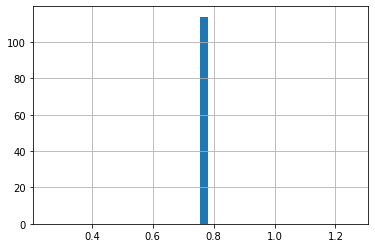

In [ ]:
pd.Series(clf.cv_results_['mean_test_score']).hist(bins = 40)
results = pd.DataFrame(clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.to_csv("results.csv")
results.iloc[0:10, :].loc[:, ['param_logr__C', 'param_logr__random_state', 'mean_test_score']]

# Так как логистическая регрессия является частным случаем нейронной сети, с той же функцией активации, то можно попробовать её в виде модели

In [ ]:
pipe_nr = Pipeline([
              ('special', Special_value(-1000)),
              ('nr', MLPClassifier((100, 100), alpha=1, max_iter=1000, random_state = 67))]
            )

In [ ]:
for i in Imputers:
    parameters = {}
    if i[0] == 'knn':
        parameters = {"knn__n_neighbors" : [2, 3, 4, 5]}
    if i[0] == 'special':
        parameters = {"special__special_value" : [0, -1, -1000, 1000, 10000000, -10000000]}
    if i[0] == 'zet':
        parameters = {"zet__competent_row_num" : [4, 5 ,6], "zet__competent_col_num" : [4, 5, 6]}
    pipe_nr = Pipeline([
              i,
              ('nr', MLPClassifier((100, 100), alpha=1, max_iter=1000, random_state = 67))]
            )
    print("nr", i[0])
    clf = GridSearchCV(pipe_nr, parameters, cv = 3, scoring = 'roc_auc').fit(X_train.to_numpy(), y_train.to_numpy())
    print(clf.cv_results_['mean_test_score'])

nr special
[0.46609907 0.50629515 0.72141383 0.69742002 0.6501548  0.60263158]
nr common
[0.4129515]
nr mean
[0.43441692]
nr svd
[0.45294118]
nr knn
[0.44427245 0.44566563 0.44478844 0.44009288]
nr rf
[0.4380289]
nr lr
[0.41031992]
nr em
[0.42352941]
nr k-means
[0.42827657]


# Лучшей заменой пропусков для сети стала - замена специальным значением( -1000)

# Перебор гиперпараметров сети

In [ ]:
pipe_nr = Pipeline([
              ('special', Special_value(-1000)),
              ('nr', MLPClassifier())]
            )

In [ ]:
hidden_layer_sizes = []
for i in [30, 45, 60, 75, 90, 105, 120]:
    for j in [30, 45, 60, 75, 90, 105, 120]:
        hidden_layer_sizes.append((i, j))

In [ ]:
X_tr = X_train.to_numpy()
y_tr = y_train.to_numpy()

parameters = {
    'nr__max_iter': [1000], 
    'nr__hidden_layer_sizes':hidden_layer_sizes,
    'nr__random_state':[42, 67, 13, 666, 17, 21]
  }
clf = GridSearchCV(pipe_nr, parameters, cv = 10, scoring = 'roc_auc', verbose=10, return_train_score=True).fit(X_tr, y_tr)

,param_nr__hidden_layer_sizes,param_nr__max_iter,param_nr__random_state,mean_test_score
120,"(60, 120)",1000,42,0.795000
103,"(60, 75)",1000,67,0.793333
206,"(90, 120)",1000,13,0.790000
267,"(120, 60)",1000,666,0.790000
290,"(120, 120)",1000,13,0.790000
127,"(75, 30)",1000,67,0.786667
28,"(30, 90)",1000,17,0.783333
273,"(120, 75)",1000,666,0.780000
200,"(90, 105)",1000,13,0.780000
167,"(75, 120)",1000,21,0.778333


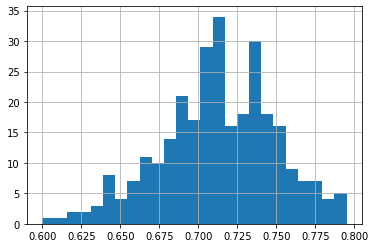

In [ ]:
pd.Series(clf.cv_results_['mean_test_score']).hist(bins = 25)
results = pd.DataFrame(clf.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.to_csv("results.csv")
results.iloc[0:10, :].loc[:, ['param_nr__hidden_layer_sizes', 'param_nr__max_iter', 'param_nr__random_state', 'mean_test_score']]

# Лучший показатель на тестовой выборке дала сеть со слоями (90, 120)	и random_state = 13

In [ ]:
pipe_ner = Pipeline(steps=[('special', Special_value(special_value=-1000)),
                ('nr',
                 MLPClassifier(hidden_layer_sizes=(90, 120), max_iter=1000, random_state=13))])

In [ ]:
roc_auc_score(y_test, pipe_ner.fit(X_train, y_train).predict(X_test))

0.8555900621118012

# Мной были получены две модели разной природы.
Известно, что если обучить несколько разных алгоритмов, то  в задаче классификации — голосование по большинству, часто превосходят по качеству все эти алгоритмы. Таким образом, можно попробовать объединить показания этих моделей при помощи Stacking.

In [316]:
pipe_nr = Pipeline(steps=[('special', Special_value(special_value=-1000)),
                ('nr',
                 MLPClassifier(hidden_layer_sizes=(90, 120), max_iter=1000, random_state=13))])

In [317]:
pipe_xgboost = Pipeline([
                    ('special', Special_value(-10000000)),
                    ('xgb', xgb.XGBClassifier(**best_estimators[0],eval_metric='mlogloss'))])


In [318]:
estimators = [
    ('xgb', pipe_xgboost),
    ('nr', pipe_nr),
]

In [319]:
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv = 5
).fit(X_train, y_train)

In [320]:
roc_auc_score(y_test, clf.predict(X_test))

0.8913043478260869

# В итоге Stacking дал прирост на test
## Таким образом была получена модель, являющаяся композицией двухслойной сети и леса, с итоговым показателем ROC AUC = 0.8913043478260869